# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/')

import pandas as pd
import re
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import torchaudio

from fastai.vision.all import *
from fastai.metrics import F1Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from collections import Counter

Mounted at /content/drive


# Functions

In [2]:
# AccentDataset class setup
max_duration = 10
sample_rate = 16000
n_mels = 128
n_fft = 512
hop_length = n_fft // 4

# AccentDataset class definition
class AccentDataset:
    def __init__(self, df, sample_rate=sample_rate, max_duration=max_duration, n_mels=n_mels,
                 n_fft=n_fft, hop_length=hop_length):
        self.df = df.copy(deep=True)
        self.sample_rate = sample_rate
        self.max_length = sample_rate * max_duration  # e.g., 5 seconds
        self.n_mels = n_mels
        self.mel_transform = torchaudio.transforms.MelSpectrogram(n_mels=n_mels,
                                                                  n_fft=n_fft,
                                                                  hop_length=hop_length)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['path']
        label = row['country_encoded']

        # Load audio
        wav, sr = torchaudio.load(path)

        # Resample if needed
        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)
            wav = resampler(wav)

        # Remove channel dimension
        wav = wav.squeeze(0)

        # Truncate or pad as needed
        num_samples = self.max_length
        if wav.shape[0] > num_samples:
            wav = wav[:num_samples]
        elif wav.shape[0] < num_samples:
            pad_len = num_samples - wav.shape[0]
            wav = torch.nn.functional.pad(wav, (0, pad_len))

        # Compute log-mel spectrogram
        mel = self.mel_transform(wav)
        mel = mel.unsqueeze(0)
        log_mel = torch.log1p(mel)  # log(1 + mel) to avoid log(0)
        log_mel = (log_mel - log_mel.mean()) / (log_mel.std() + 1e-6)

        return log_mel, torch.tensor(label, dtype=torch.long)

# Performance metrics
def per_class_accuracy(preds, labels, num_countries):
    preds = np.array(preds)
    labels = np.array(labels)

    accs = []
    for cls in range(num_countries):
        idxs = labels == cls
        if idxs.sum() == 0:
            accs.append(np.nan)
        else:
            accs.append((preds[idxs] == labels[idxs]).mean())
    return accs

# LTSM
class PermuteAndReshape(nn.Module):
    def forward(self, x):
        B, C, T, F = x.size()
        x = x.permute(0, 2, 1, 3).contiguous()
        return x.view(B, T, C * F)

class LSTMWrapper(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

    def forward(self, x):
        output, _ = self.lstm(x)
        return output[:, -1, :]

# Read in data

Clean data

In [3]:
df = pd.read_csv('SpeechAccentArchive/audio_metadata.csv')

# Clean up labels
countries = np.array(df['country'])
scripts = np.array(df['transcript'])
audio_paths = np.array(df['path'])
mask = np.array([len(countries[ind].split(',')) == 1 for ind in range(len(countries))], dtype=bool) # remove samples from multiple countries
countries, scripts, audio_paths = countries[mask], scripts[mask], audio_paths[mask]
countries = countries.astype(object)
countries[countries == 'ausstralia'] = 'australia'
countries[countries == 'USA'] = 'usa'
counts = df['country'].value_counts()

df_data = pd.DataFrame({'path': audio_paths, 'script': scripts, 'country': countries})
df_data['country'] = df_data['country'].apply(lambda x: x if counts[x] >= 2 else 'other') # classifies accents with <2 samples as "other"

# Encode labels
codes, uniques = pd.factorize(df_data['country'])
df_data['country_encoded'] = codes
mapping = {country: idx for idx, country in enumerate(uniques)}
inverse_mapping = {v: k for k, v in mapping.items()}

print("Mapping:", mapping)
df_data.head()

Mapping: {'usa': 0, 'uk': 1, 'australia': 2, 'canada': 3, 'new zealand': 4, 'south africa': 5, 'other': 6, 'ireland': 7, 'jamaica': 8, 'singapore': 9}


,path,script,country,country_encoded
0,SpeechAccentArchive/english1.mp3,"\r\nPlease call Stella. Ask her to bring these things with her from\r\n the store: Six spoons of fresh snow peas, five thick slabs of blue\r\n cheese, and maybe a snack for her brother Bob. We also need a small\r\n plastic snake and a big toy frog for the kids. She can scoop these\r\n things into three red bags, and we will go meet her Wednesday at the\r\n train station.\r\n \r\n",usa,0
1,SpeechAccentArchive/english2.mp3,"\r\nPlease call Stella. Ask her to bring these things with her from\r\n the store: Six spoons of fresh snow peas, five thick slabs of blue\r\n cheese, and maybe a snack for her brother Bob. We also need a small\r\n plastic snake and a big toy frog for the kids. She can scoop these\r\n things into three red bags, and we will go meet her Wednesday at the\r\n train station.\r\n \r\n",uk,1
2,SpeechAccentArchive/english3.mp3,"\r\nPlease call Stella. Ask her to bring these things with her from\r\n the store: Six spoons of fresh snow peas, five thick slabs of blue\r\n cheese, and maybe a snack for her brother Bob. We also need a small\r\n plastic snake and a big toy frog for the kids. She can scoop these\r\n things into three red bags, and we will go meet her Wednesday at the\r\n train station.\r\n \r\n",australia,2
3,SpeechAccentArchive/english5.mp3,"\r\nPlease call Stella. Ask her to bring these things with her from\r\n the store: Six spoons of fresh snow peas, five thick slabs of blue\r\n cheese, and maybe a snack for her brother Bob. We also need a small\r\n plastic snake and a big toy frog for the kids. She can scoop these\r\n things into three red bags, and we will go meet her Wednesday at the\r\n train station.\r\n \r\n",usa,0
4,SpeechAccentArchive/english6.mp3,"\r\nPlease call Stella. Ask her to bring these things with her from\r\n the store: Six spoons of fresh snow peas, five thick slabs of blue\r\n cheese, and maybe a snack for her brother Bob. We also need a small\r\n plastic snake and a big toy frog for the kids. She can scoop these\r\n things into three red bags, and we will go meet her Wednesday at the\r\n train station.\r\n \r\n",usa,0


In [4]:
df_data['country'].value_counts()

,count
country,
usa,435
uk,45
canada,42
australia,37
ireland,12
other,7
new zealand,6
singapore,5
south africa,4


Set up training and validation sets

In [5]:
# Split data into training and validation
num_train = int(0.8 * len(df_data))
num_val = len(df_data) - num_train
num_countries = len(set(df_data['country_encoded']))

train_df, val_df = train_test_split(
    df_data,
    test_size=0.2,
    stratify=df_data['country_encoded'],  # ensures all classes are represented
    random_state=42
)
train_ds = AccentDataset(train_df)
val_ds = AccentDataset(val_df)

# Dataloaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=True)
dls = DataLoaders(train_dl, val_dl)

# Calculate weights to account for imbalanced classes
labels = [int(y) for _, y in dls.train_ds]
class_counts = Counter(labels)
counts_sorted = [class_counts.get(i) for i in range(num_countries)]

inv_freqs = [1.0 / c for c in counts_sorted]
normalized_weights = [w / sum(inv_freqs) for w in inv_freqs]

class_weights = torch.tensor(normalized_weights, dtype=torch.float32)

# Data properties
features = num_countries*2 # runs out of RAM >2**10
sample_input, _ = train_ds[0]
data_dim = np.prod(sample_input.shape)
num_countries = len(set(df_data['country_encoded']))

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


# Simple NN model

5 linear layers

In [ ]:
model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(data_dim, features),
            nn.ReLU(),
            nn.Linear(features, 2*features),
            nn.ReLU(),
            nn.Linear(2*features, 4*features),
            nn.ReLU(),
            nn.Linear(4*features, 8*features),
            nn.ReLU(),
            nn.Linear(8*features, num_countries)
        )

learn = Learner(dls, model, opt_func=SGD,
                loss_func=CrossEntropyLossFlat(weight=class_weights),
                metrics=[accuracy, F1Score(average='macro')]) # CrossEntropyLoss for single-label classification according to FastAI chapter 6
learn.fit(1) # argument in parentheses is number of epochs

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.296454,2.302578,0.025210,0.017143,01:58


Optimize learning rate

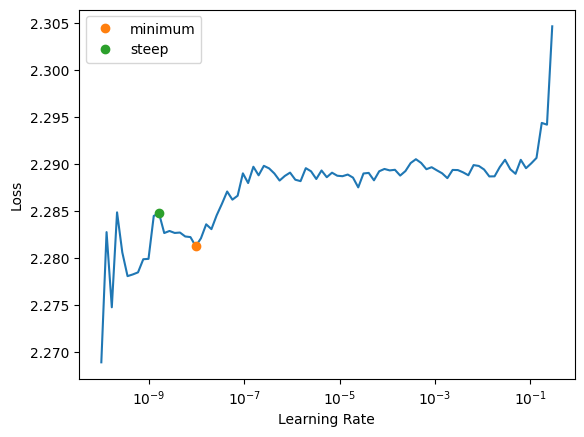

In [ ]:
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep), start_lr=1e-10, end_lr=1e1)

In [ ]:
learn.fine_tune(20, base_lr=1e-6)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.287255,2.298299,0.025210,0.017143,00:40


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.290958,2.303301,0.025210,0.017143,00:42
1,2.290420,2.296179,0.025210,0.017143,00:41
2,2.291239,2.300647,0.025210,0.017143,00:51
3,2.290747,2.297414,0.025210,0.017143,00:52
4,2.290752,2.300521,0.025210,0.017143,00:55
5,2.289375,2.299825,0.025210,0.017143,00:45
6,2.289371,2.306373,0.025210,0.017143,00:46
7,2.288450,2.297740,0.025210,0.017143,00:43
8,2.289641,2.292104,0.025210,0.017143,00:41
9,2.289113,2.297620,0.025210,0.017143,00:49


Model performance

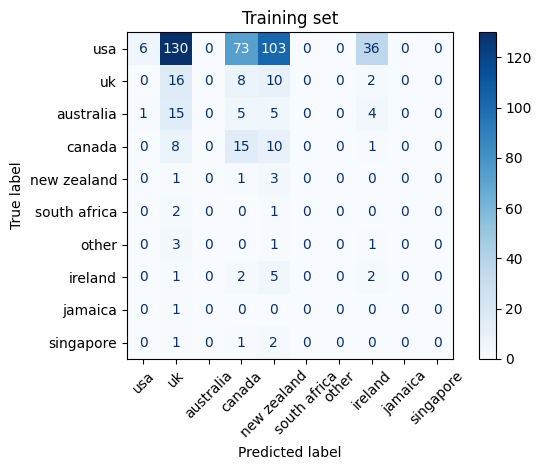

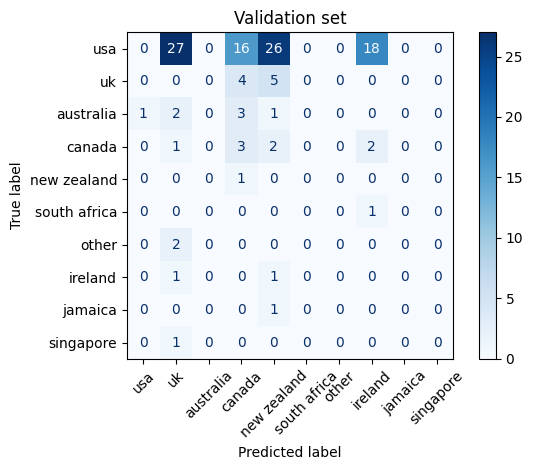

In [ ]:
preds, _ = learn.get_preds(dl=train_dl)
train_preds = preds.argmax(dim=1)
train_labels = list(train_ds.df['country_encoded'])

preds, _ = learn.get_preds(dl=val_dl)
val_preds = preds.argmax(dim=1)
val_labels = list(val_ds.df['country_encoded'])

train_cm = confusion_matrix(train_labels, train_preds)
val_cm = confusion_matrix(val_labels, val_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=mapping.keys())
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.title('Training set')
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=mapping.keys())
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.title('Validation set')
plt.show()

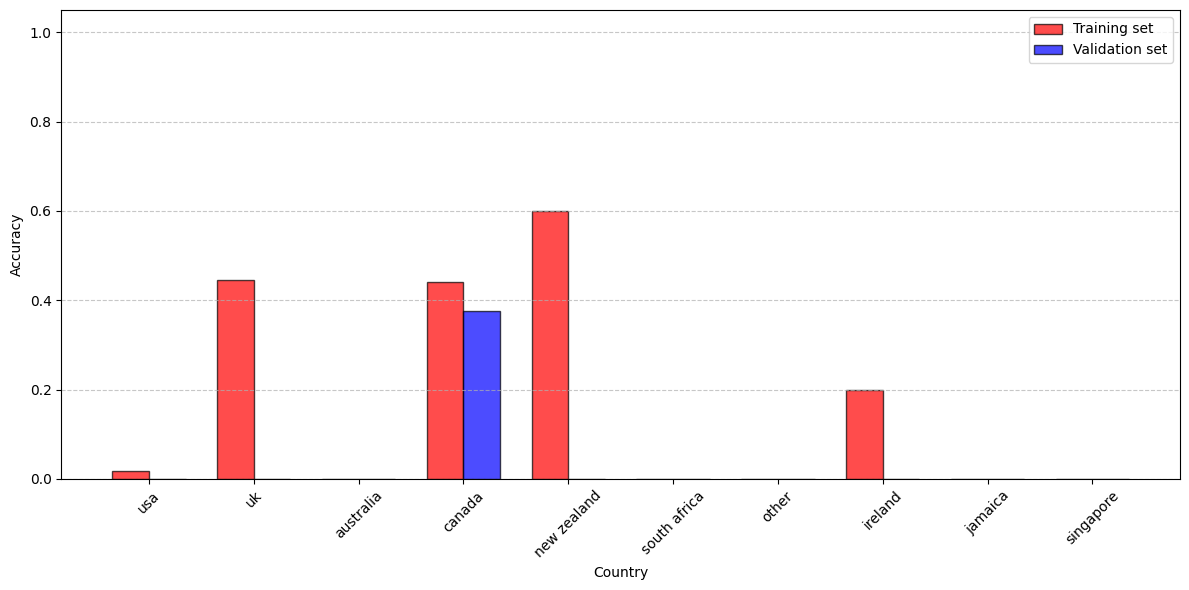

In [ ]:
# Compute accuracy for each accent
train_accs = per_class_accuracy(train_preds, train_labels, num_countries)
val_accs = per_class_accuracy(val_preds, val_labels, num_countries)

# X-axis labels
x = np.arange(num_countries)
width = 0.35
x_labels = [next(k for k, v in mapping.items() if v == i) for i in range(num_countries)]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, train_accs, width, label='Training set', color='red', alpha=0.7, edgecolor='k')
plt.bar(x + width/2, val_accs, width, label='Validation set', color='blue', alpha=0.7, edgecolor='k')
plt.xlabel('Country')
plt.ylabel('Accuracy')
plt.xticks(x, x_labels, rotation=45)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

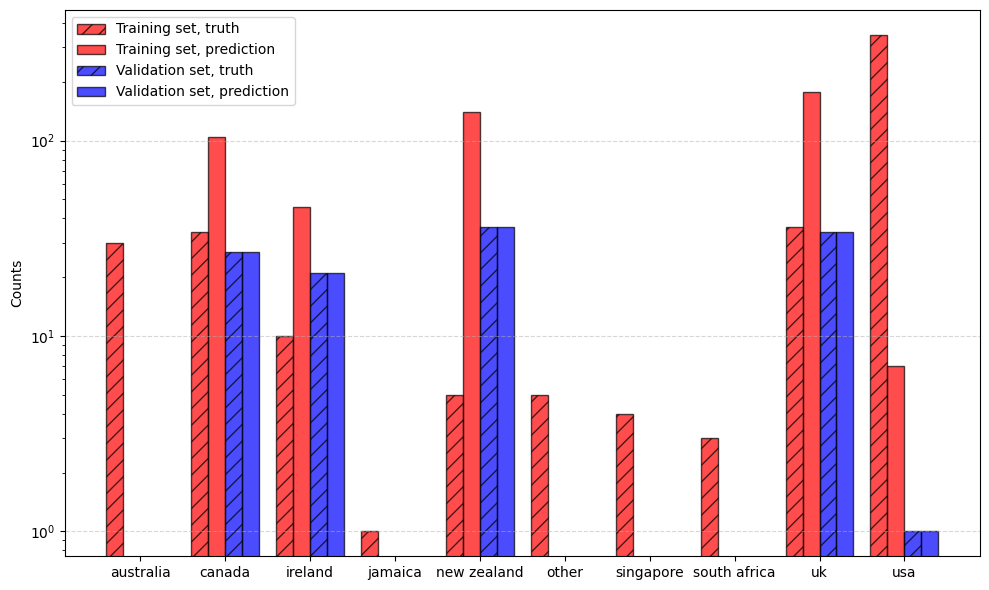

In [ ]:
train_labels_counts = pd.DataFrame(np.vectorize(inverse_mapping.get)(train_labels)).value_counts()
train_preds_counts = pd.DataFrame(np.vectorize(inverse_mapping.get)(train_preds.numpy())).value_counts()
val_labels_counts = pd.DataFrame(np.vectorize(inverse_mapping.get)(val_preds.numpy())).value_counts()
val_preds_counts = pd.DataFrame(np.vectorize(inverse_mapping.get)(val_preds.numpy())).value_counts()

train_labels_counts.index = [i[0] if isinstance(i, tuple) else i for i in train_labels_counts.index]
train_preds_counts.index = [i[0] if isinstance(i, tuple) else i for i in train_preds_counts.index]
val_labels_counts.index = [i[0] if isinstance(i, tuple) else i for i in val_labels_counts.index]
val_preds_counts.index = [i[0] if isinstance(i, tuple) else i for i in val_preds_counts.index]

df = pd.DataFrame({
    'Train Labels': train_labels_counts,
    'Train Preds': train_preds_counts,
    'Val Labels': val_labels_counts,
    'Val Preds': val_preds_counts
})

labels = df.index.tolist()
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

bars_train_labels = ax.bar(x - 1.5*width, df['Train Labels'], width, color='red', label='Training set, truth', hatch='//', alpha=0.7, edgecolor='k')
bars_train_preds = ax.bar(x - 0.5*width, df['Train Preds'], width, color='red', label='Training set, prediction', alpha=0.7, edgecolor='k')
bars_val_labels = ax.bar(x + 0.5*width, df['Val Labels'], width, color='blue', label='Validation set, truth', hatch='//', alpha=0.7, edgecolor='k')
bars_val_preds = ax.bar(x + 1.5*width, df['Val Preds'], width, color='blue', label='Validation set, prediction', alpha=0.7, edgecolor='k')

ax.set_yscale('log')
ax.set_ylabel('Counts')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.5)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left')

plt.tight_layout()
plt.show()

# CNN model

5 convolution layers and 1 linear layer

In [7]:
model = nn.Sequential(
        nn.BatchNorm2d(1),
        nn.Conv2d(1, 2, kernel_size=7, padding=7//2),
        nn.BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(2, 4, kernel_size=7, padding=7//2),
        nn.BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(4, 8, kernel_size=7, padding=7//2),
        nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(8, 16, kernel_size=7, padding=7//2),
        nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 32, kernel_size=7, padding=7//2),
        nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(4992, num_countries)
        )

learn = Learner(dls, model, opt_func=SGD,
                loss_func=CrossEntropyLossFlat(weight=class_weights),
                metrics=[accuracy, F1Score(average='macro')]) # CrossEntropyLoss for single-label classification according to FastAI chapter 6
learn.fit(1) # argument in parentheses is number of epochs

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.809210,2.581438,0.226891,0.066917,02:07


Optimize learning rate

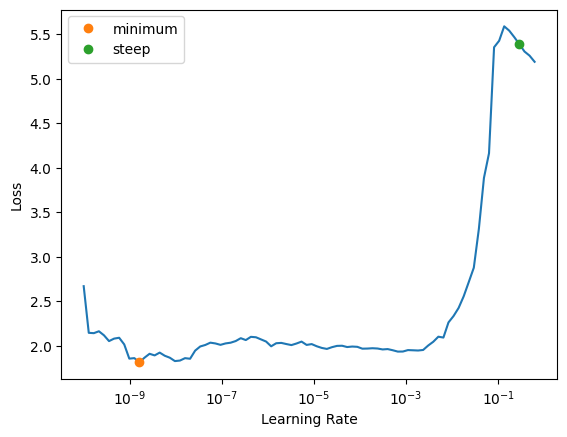

In [ ]:
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep), start_lr=1e-10, end_lr=1e1)

In [8]:
learn.fine_tune(20, base_lr=1e-9)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.981402,2.610515,0.226891,0.069526,01:28


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.908870,2.680434,0.226891,0.069889,01:31
1,2.000051,2.707614,0.235294,0.071661,01:34
2,1.976202,2.825741,0.235294,0.071661,01:29
3,1.973807,2.845243,0.235294,0.071661,01:32
4,1.981345,2.732280,0.235294,0.071661,01:32
5,1.974180,2.879518,0.235294,0.071661,01:30
6,1.978211,2.674843,0.235294,0.071661,01:30
7,1.984025,2.628765,0.235294,0.071661,01:37
8,1.981980,2.428917,0.235294,0.071661,01:30
9,1.989514,2.859206,0.235294,0.071661,01:32


Model performance

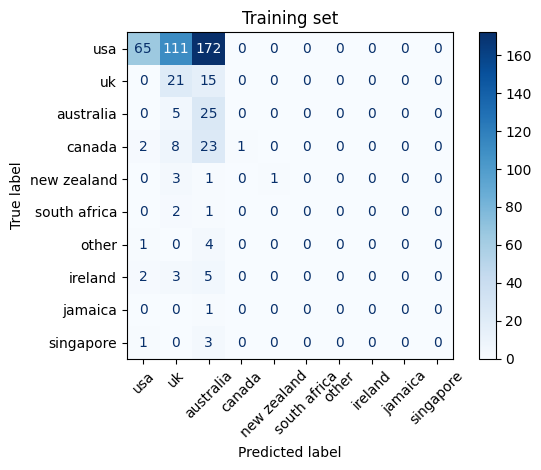

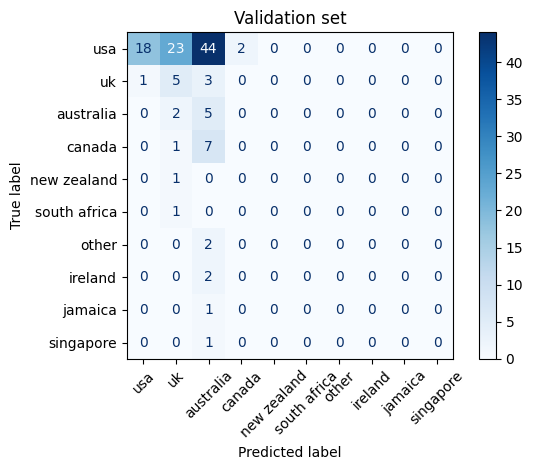

In [9]:
preds, _ = learn.get_preds(dl=train_dl)
train_preds = preds.argmax(dim=1)
train_labels = list(train_ds.df['country_encoded'])

preds, _ = learn.get_preds(dl=val_dl)
val_preds = preds.argmax(dim=1)
val_labels = list(val_ds.df['country_encoded'])

train_cm = confusion_matrix(train_labels, train_preds)
val_cm = confusion_matrix(val_labels, val_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=mapping.keys())
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.title('Training set')
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=mapping.keys())
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.title('Validation set')
plt.show()

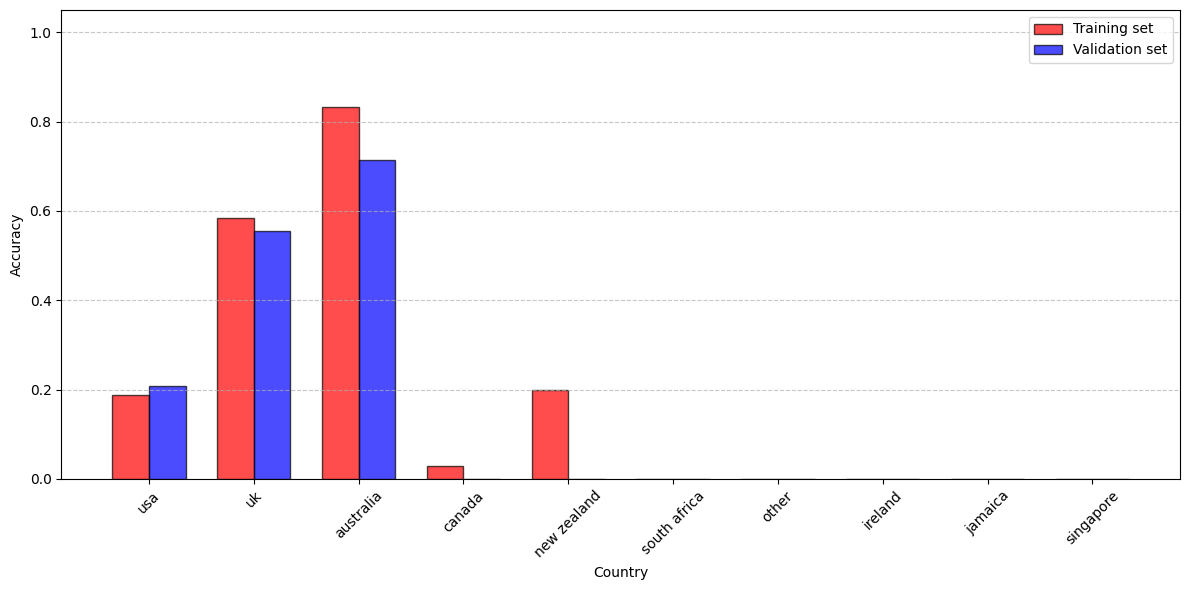

In [10]:
# Compute accuracy for each accent
train_accs = per_class_accuracy(train_preds, train_labels, num_countries)
val_accs = per_class_accuracy(val_preds, val_labels, num_countries)

# X-axis labels
x = np.arange(num_countries)
width = 0.35
x_labels = [next(k for k, v in mapping.items() if v == i) for i in range(num_countries)]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, train_accs, width, label='Training set', color='red', alpha=0.7, edgecolor='k')
plt.bar(x + width/2, val_accs, width, label='Validation set', color='blue', alpha=0.7, edgecolor='k')
plt.xlabel('Country')
plt.ylabel('Accuracy')
plt.xticks(x, x_labels, rotation=45)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

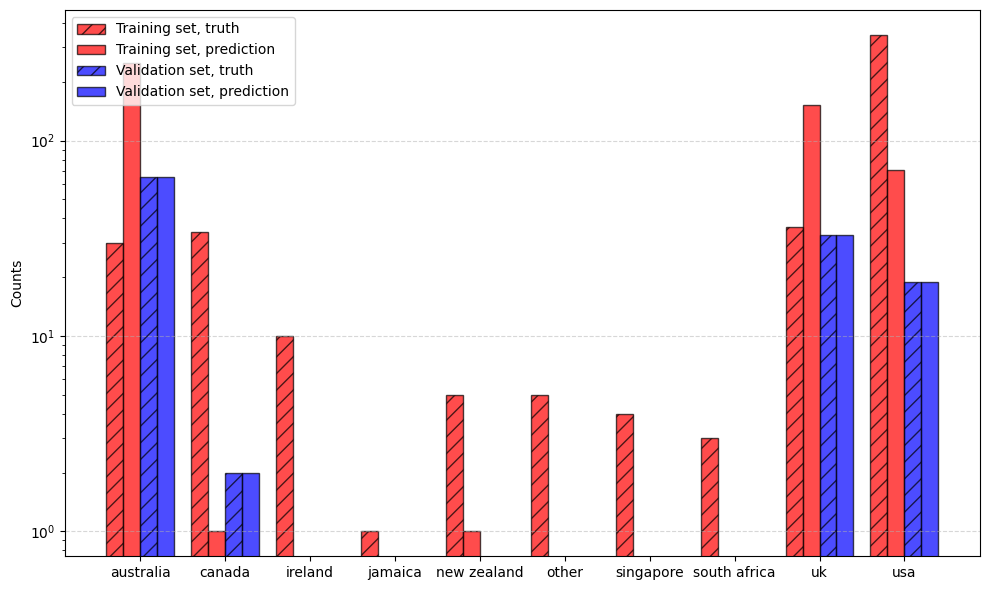

In [11]:
train_labels_counts = pd.DataFrame(np.vectorize(inverse_mapping.get)(train_labels)).value_counts()
train_preds_counts = pd.DataFrame(np.vectorize(inverse_mapping.get)(train_preds.numpy())).value_counts()
val_labels_counts = pd.DataFrame(np.vectorize(inverse_mapping.get)(val_preds.numpy())).value_counts()
val_preds_counts = pd.DataFrame(np.vectorize(inverse_mapping.get)(val_preds.numpy())).value_counts()

train_labels_counts.index = [i[0] if isinstance(i, tuple) else i for i in train_labels_counts.index]
train_preds_counts.index = [i[0] if isinstance(i, tuple) else i for i in train_preds_counts.index]
val_labels_counts.index = [i[0] if isinstance(i, tuple) else i for i in val_labels_counts.index]
val_preds_counts.index = [i[0] if isinstance(i, tuple) else i for i in val_preds_counts.index]

df = pd.DataFrame({
    'Train Labels': train_labels_counts,
    'Train Preds': train_preds_counts,
    'Val Labels': val_labels_counts,
    'Val Preds': val_preds_counts
})

labels = df.index.tolist()
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

bars_train_labels = ax.bar(x - 1.5*width, df['Train Labels'], width, color='red', label='Training set, truth', hatch='//', alpha=0.7, edgecolor='k')
bars_train_preds = ax.bar(x - 0.5*width, df['Train Preds'], width, color='red', label='Training set, prediction', alpha=0.7, edgecolor='k')
bars_val_labels = ax.bar(x + 0.5*width, df['Val Labels'], width, color='blue', label='Validation set, truth', hatch='//', alpha=0.7, edgecolor='k')
bars_val_preds = ax.bar(x + 1.5*width, df['Val Preds'], width, color='blue', label='Validation set, prediction', alpha=0.7, edgecolor='k')

ax.set_yscale('log')
ax.set_ylabel('Counts')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.5)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left')

plt.tight_layout()
plt.show()

# CNN + LSTM model

5 convolution layers, 1 LSTM layer, and 1 linear layer

In [14]:
model = nn.Sequential(
    nn.Conv2d(1, 2, kernel_size=3, padding=1),
    nn.BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(2, 4, kernel_size=3, padding=1),
    nn.BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(4, 8, kernel_size=3, padding=1),
    nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(8, 16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    nn.MaxPool2d(2),

    PermuteAndReshape(),

    LSTMWrapper(input_size=1248, hidden_size=128, num_layers=2),

    nn.Linear(128 * 2, num_countries)
)

learn = Learner(dls, model, opt_func=SGD,
                loss_func=CrossEntropyLossFlat(weight=class_weights),
                metrics=[accuracy, F1Score(average='macro')]) # CrossEntropyLoss for single-label classification according to FastAI chapter 6
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.317651,2.321463,0.050420,0.011215,00:50


Optimize learning rate

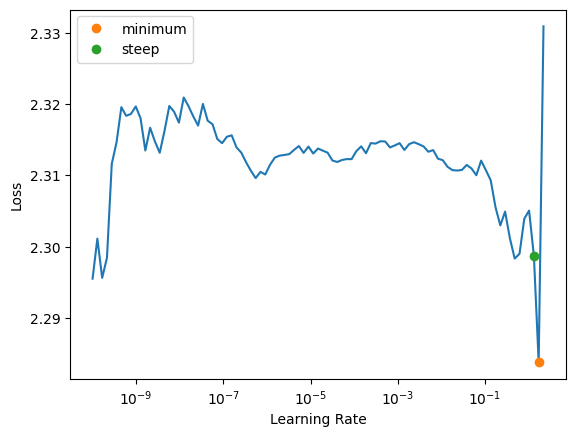

In [15]:
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep), start_lr=1e-10, end_lr=1e1)

In [16]:
learn.fine_tune(20, base_lr=1e-7)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.314298,2.326448,0.033613,0.018333,00:52


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.313727,2.317055,0.033613,0.018333,00:50
1,2.312590,2.308224,0.033613,0.018451,00:52
2,2.312761,2.306779,0.033613,0.018333,00:50
3,2.312557,2.322670,0.033613,0.018571,00:50
4,2.314750,2.310197,0.033613,0.018333,00:51
5,2.313713,2.313538,0.033613,0.018571,00:51
6,2.315638,2.304199,0.042017,0.020959,00:51
7,2.312832,2.305847,0.033613,0.018451,00:52
8,2.311877,2.316806,0.033613,0.018571,00:50
9,2.315434,2.311561,0.033613,0.018571,00:51


Model performance

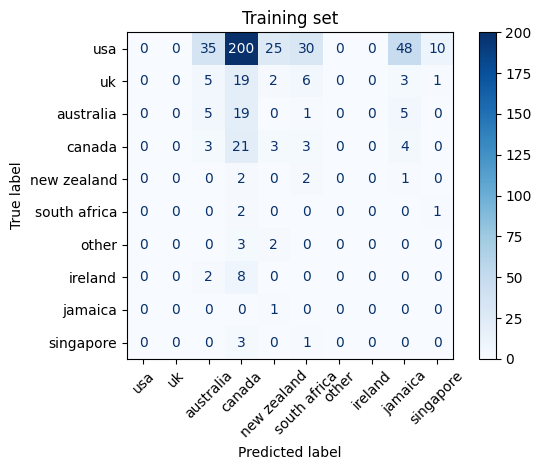

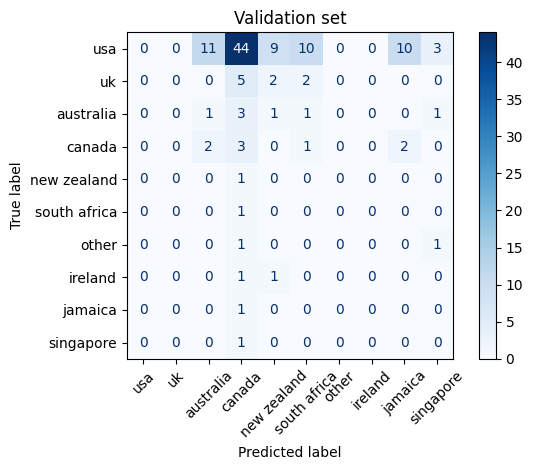

In [17]:
preds, _ = learn.get_preds(dl=train_dl)
train_preds = preds.argmax(dim=1)
train_labels = list(train_ds.df['country_encoded'])

preds, _ = learn.get_preds(dl=val_dl)
val_preds = preds.argmax(dim=1)
val_labels = list(val_ds.df['country_encoded'])

train_cm = confusion_matrix(train_labels, train_preds)
val_cm = confusion_matrix(val_labels, val_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=mapping.keys())
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.title('Training set')
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=mapping.keys())
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.title('Validation set')
plt.show()

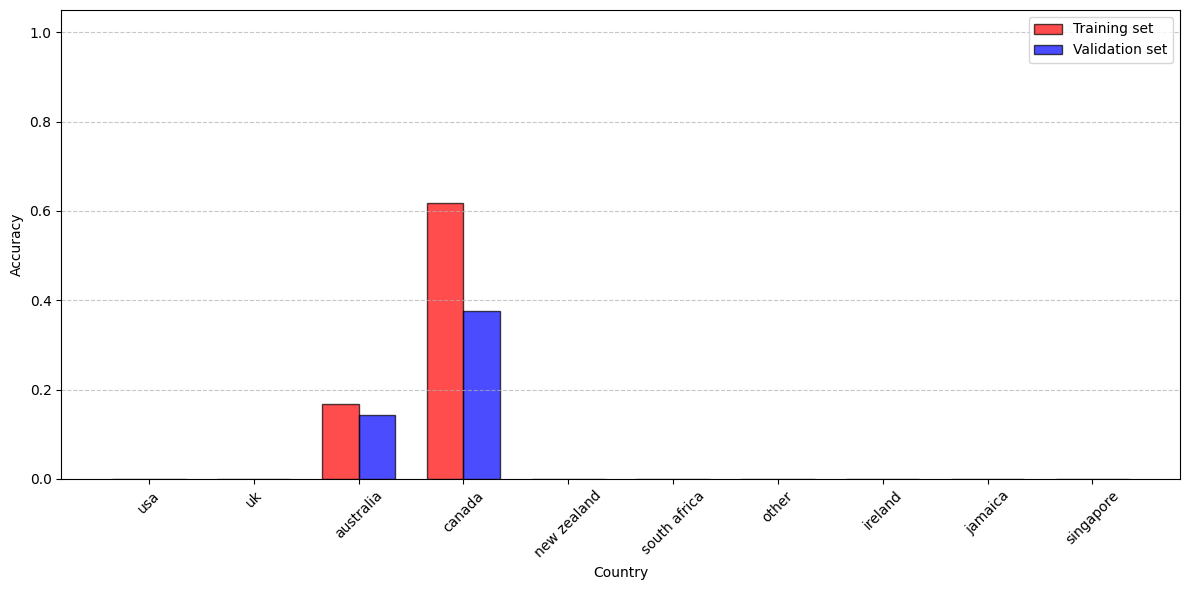

In [18]:
# Compute accuracy for each accent
train_accs = per_class_accuracy(train_preds, train_labels, num_countries)
val_accs = per_class_accuracy(val_preds, val_labels, num_countries)

# X-axis labels
x = np.arange(num_countries)
width = 0.35
x_labels = [next(k for k, v in mapping.items() if v == i) for i in range(num_countries)]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, train_accs, width, label='Training set', color='red', alpha=0.7, edgecolor='k')
plt.bar(x + width/2, val_accs, width, label='Validation set', color='blue', alpha=0.7, edgecolor='k')
plt.xlabel('Country')
plt.ylabel('Accuracy')
plt.xticks(x, x_labels, rotation=45)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

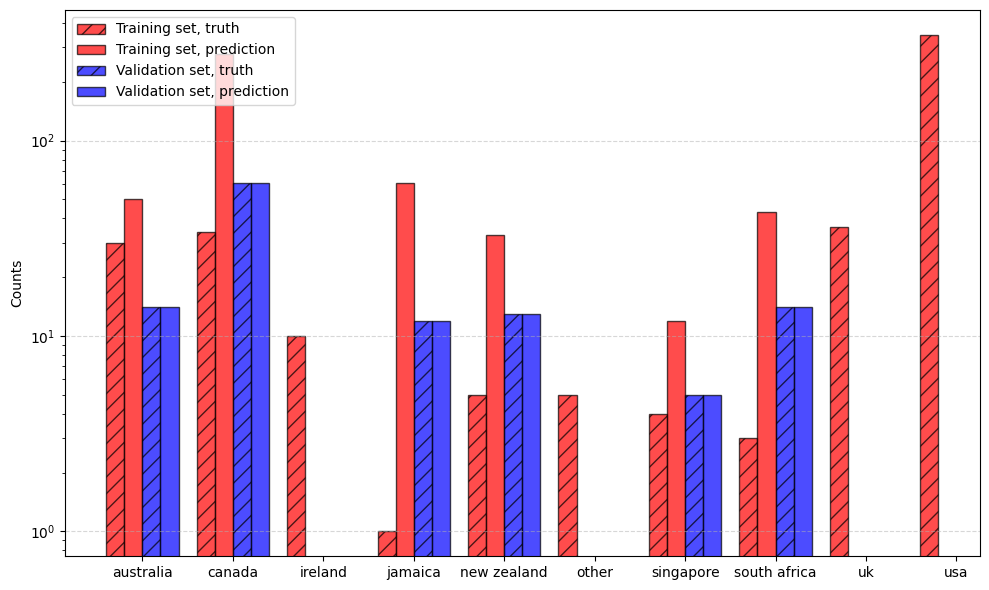

In [19]:
train_labels_counts = pd.DataFrame(np.vectorize(inverse_mapping.get)(train_labels)).value_counts()
train_preds_counts = pd.DataFrame(np.vectorize(inverse_mapping.get)(train_preds.numpy())).value_counts()
val_labels_counts = pd.DataFrame(np.vectorize(inverse_mapping.get)(val_preds.numpy())).value_counts()
val_preds_counts = pd.DataFrame(np.vectorize(inverse_mapping.get)(val_preds.numpy())).value_counts()

train_labels_counts.index = [i[0] if isinstance(i, tuple) else i for i in train_labels_counts.index]
train_preds_counts.index = [i[0] if isinstance(i, tuple) else i for i in train_preds_counts.index]
val_labels_counts.index = [i[0] if isinstance(i, tuple) else i for i in val_labels_counts.index]
val_preds_counts.index = [i[0] if isinstance(i, tuple) else i for i in val_preds_counts.index]

df = pd.DataFrame({
    'Train Labels': train_labels_counts,
    'Train Preds': train_preds_counts,
    'Val Labels': val_labels_counts,
    'Val Preds': val_preds_counts
})

labels = df.index.tolist()
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

bars_train_labels = ax.bar(x - 1.5*width, df['Train Labels'], width, color='red', label='Training set, truth', hatch='//', alpha=0.7, edgecolor='k')
bars_train_preds = ax.bar(x - 0.5*width, df['Train Preds'], width, color='red', label='Training set, prediction', alpha=0.7, edgecolor='k')
bars_val_labels = ax.bar(x + 0.5*width, df['Val Labels'], width, color='blue', label='Validation set, truth', hatch='//', alpha=0.7, edgecolor='k')
bars_val_preds = ax.bar(x + 1.5*width, df['Val Preds'], width, color='blue', label='Validation set, prediction', alpha=0.7, edgecolor='k')

ax.set_yscale('log')
ax.set_ylabel('Counts')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.5)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left')

plt.tight_layout()
plt.show()

In [20]:
learn.save('CNN_LSTM_model')

Path('models/CNN_LSTM_model.pth')